In [2]:
import serial
import serial.tools.list_ports
import pandas as pd
import time
import os

def select_serial_port():
    """Menampilkan daftar port serial yang tersedia dan meminta pengguna untuk memilih."""
    ports = serial.tools.list_ports.comports()
    print("Port serial yang tersedia:")
    
    if not ports:
        print("-> Tidak ada port serial yang ditemukan. Pastikan perangkat Anda terhubung.")
        return None

    for i, port in enumerate(ports):
        print(f"  {i + 1}: {port.device} - {port.description}")
    
    while True:
        try:
            choice = int(input("Pilih nomor port untuk ESP32 Anda: "))
            if 1 <= choice <= len(ports):
                return ports[choice - 1].device
            else:
                print("Pilihan tidak valid. Silakan pilih nomor dari daftar.")
        except (ValueError, IndexError):
            print("Input tidak valid. Harap masukkan nomor.")

def main():
    """
    Fungsi utama untuk menangkap data benchmark dari serial dan menyimpannya ke Excel.
    """
    # --- 1. Konfigurasi oleh Pengguna ---
    port = select_serial_port()
    if not port:
        return

    baud_rate = 115200  # Sesuai dengan Serial.begin(115200) di kode C++
    output_filename = input("Masukkan nama untuk file Excel keluaran (contoh: hasil_benchmark.xlsx): ")
    if not output_filename.lower().endswith('.xlsx'):
        output_filename += '.xlsx'
        
    print("\n--- Konfigurasi ---")
    print(f"  Port        : {port}")
    print(f"  Baud Rate   : {baud_rate}")
    print(f"  File Output : {output_filename}")
    
    # --- 2. Proses Penangkapan Data ---
    data_rows = []
    summary_data = {}
    column_headers = []
    is_reading_data = False

    try:
        # Menggunakan timeout untuk mencegah skrip macet jika tidak ada data masuk
        with serial.Serial(port, baud_rate, timeout=10) as ser: # Timeout 10 detik
            print("\nKoneksi berhasil. Menunggu data...")
            print(">>> Harap RESET papan ESP32 Anda sekarang untuk memulai proses benchmark. <<<")
            
            while True:
                line_bytes = ser.readline()
                if not line_bytes:
                    # Timeout terjadi, diasumsikan transmisi data selesai
                    print("\nTidak ada data diterima selama 10 detik. Proses dianggap selesai.")
                    break

                # Decode byte menjadi string dan bersihkan spasi
                line = line_bytes.decode('utf-8', errors='ignore').strip()
                if line:
                    print(f"Diterima: {line}")

                # === PERUBAHAN LOGIKA PARSING DIMULAI DI SINI ===

                # Logika baru untuk mendeteksi header tabel
                if "Sample" in line and "Actual" in line and "Predicted" in line:
                    # Mengambil header dari baris, membersihkan spasi ekstra
                    column_headers = [h.strip() for h in line.split('\t') if h.strip()]
                    is_reading_data = True
                    continue
                
                # Menggunakan "===" sebagai penanda akhir tabel data, lebih robust
                if "===" in line:
                    is_reading_data = False
                    continue

                if is_reading_data:
                    # Ini adalah baris data tabel
                    # Memisahkan berdasarkan tab dan menghapus entri kosong
                    values = [v.strip() for v in line.split('\t') if v.strip()]
                    
                    try:
                        # Konversi semua nilai menjadi angka (float)
                        typed_values = [float(v) for v in values]
                        data_rows.append(typed_values)
                    except (ValueError, IndexError):
                        print(f"Peringatan: Melewati baris data yang tidak sesuai format: {line}")

                # Logika baru untuk parsing baris ringkasan
                if "Akurasi Test:" in line:
                    # Ekstrak nilai akurasi
                    accuracy_value = float(line.split(':')[1].strip().split(' ')[0])
                    summary_data["Metrik"] = ["Akurasi Test (%)", "Rata-rata Waktu Inferensi (us)"]
                    summary_data["Nilai"] = [accuracy_value]

                if "Rata-rata waktu inferensi:" in line:
                    # Ekstrak nilai waktu
                    time_value_str = line.split(':')[1].strip().split(' ')[0]
                    time_value = float(time_value_str)
                    
                    # Pastikan dictionary sudah diinisialisasi
                    if "Nilai" in summary_data:
                        summary_data["Nilai"].append(time_value)
                    
                    # Benchmark selesai setelah baris ini, keluar dari loop
                    time.sleep(0.5) # Beri jeda singkat untuk memastikan semua data diterima
                    break
                
                # === AKHIR PERUBAHAN LOGIKA PARSING ===

    except serial.SerialException as e:
        print(f"\nERROR: Tidak dapat membuka port {port}. {e}")
        return
    except Exception as e:
        print(f"\nTerjadi kesalahan tak terduga: {e}")
        return

    # --- 3. Proses dan Ekspor Data ke Excel ---
    if not data_rows:
        print("\nTidak ada data valid yang ditangkap. File Excel tidak akan dibuat.")
        return

    print("\nPenangkapan data selesai. Menyiapkan file Excel...")

    try:
        # Jika karena suatu alasan header tidak tertangkap, gunakan header default
        if not column_headers:
             column_headers = ['Sample', 'Actual', 'Predicted', 'Time (us)']

        # Buat DataFrame dari data yang terkumpul
        # Menyesuaikan jumlah kolom header dengan jumlah kolom data secara dinamis
        df_data = pd.DataFrame(data_rows, columns=column_headers[:len(data_rows[0])])
        df_summary = pd.DataFrame(summary_data)

        # Tulis DataFrame ke file Excel
        with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
            df_data.to_excel(writer, sheet_name='Hasil Benchmark', index=False)
            
            # Tambahkan ringkasan di bawah tabel utama, berikan jarak 2 baris
            start_row_summary = len(df_data) + 3
            df_summary.to_excel(writer, sheet_name='Hasil Benchmark', index=False, startrow=start_row_summary, header=True)
        
        print(f"\nBERHASIL! Data telah disimpan ke '{os.path.abspath(output_filename)}'")

    except Exception as e:
        print(f"\nERROR: Gagal menulis ke file Excel: {e}")

if __name__ == "__main__":
    main()

Port serial yang tersedia:
  1: COM3 - USB Serial Device (COM3)
  2: COM7 - Standard Serial over Bluetooth link (COM7)
  3: COM6 - Standard Serial over Bluetooth link (COM6)

--- Konfigurasi ---
  Port        : COM3
  Baud Rate   : 115200
  File Output : C_3_I_RP2350.xlsx

Koneksi berhasil. Menunggu data...
>>> Harap RESET papan ESP32 Anda sekarang untuk memulai proses benchmark. <<<
Diterima: --- TFLite INT8 Model Benchmark (Case C, Accuracy) for RP2350/RP2040 ---
Diterima: Starting benchmark for INT8 model (Case C)...
Diterima: --------------------------------------------------
Diterima: Sample	Actual	Predicted	Time (us)
Diterima: --------------------------------------------------
Peringatan: Melewati baris data yang tidak sesuai format: --------------------------------------------------
Diterima: 0	1	0	737
Diterima: 1	1	1	452
Diterima: 2	0	0	363
Diterima: 3	0	0	371
Diterima: 4	1	1	412
Diterima: 5	0	0	356
Diterima: 6	1	1	368
Diterima: 7	1	1	349
Diterima: 8	1	1	366
Diterima: 9	1	1	404

=== Perbandingan Confusion Matrix C-4 (ESP32) ===


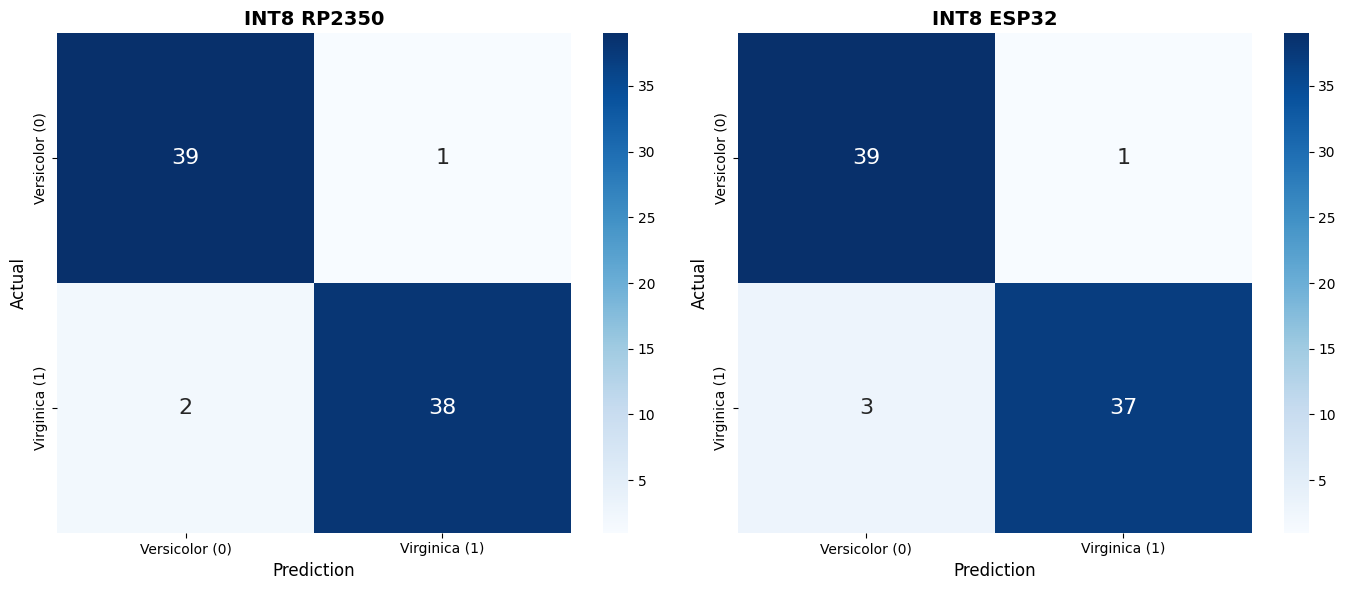

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_combined_confusion_matrix(file_path1, name1, file_path2, name2):
    # Setup figure dengan 2 subplot bersebelahan
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    files = [(file_path1, name1), (file_path2, name2)]
    
    for i, (file_path, model_name) in enumerate(files):
        # Memuat dan memproses data
        df = pd.read_excel(file_path)
        df_subset = df.iloc[:80].copy()
        
        # Konversi ke integer
        df_subset['Actual'] = df_subset['Actual'].astype(int)
        df_subset['Predicted'] = df_subset['Predicted'].astype(int)
        
        y_true = df_subset['Actual']
        y_pred = df_subset['Predicted']
        
        # Label dan nama kelas
        labels = [0, 1]
        class_names = ['Versicolor (0)', 'Virginica (1)']
        
        # Hitung confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        
        # Plot di subplot yang sesuai (axes[0] atau axes[1])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=class_names, yticklabels=class_names, 
                    annot_kws={"size": 16})
        
        axes[i].set_title(f'{model_name}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Prediction', fontsize=12)
        axes[i].set_ylabel('Actual', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Path file (sesuaikan path Anda)
file_rp2350 = './Hasil_Benchmark/C_4_I_RP2350.xlsx' 
file_esp32 = './Hasil_Benchmark/C_4_I_ESP32.xlsx'

# Panggil fungsi
print("=== Perbandingan Confusion Matrix C-4 (ESP32) ===")
plot_combined_confusion_matrix(file_rp2350, "INT8 RP2350", 
                               file_esp32, "INT8 ESP32")